# <p><span style="color: yellow;">IMPORT MODULE</span></p>

In [34]:
import cv2 as cv
import os
import matplotlib.pyplot as plt
import fnmatch
from tqdm import tqdm
import numpy as np

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

import shutil

In [2]:
# Set Dir
dir_train = 'images/train'
# dir_validation = '/content/drive/MyDrive/SCRIPTC/SFEW_2/Val'
dir_test = 'images/test'

# <p><span style="color: yellow;">Getting Path And Histogram</span></p>

## <p><span style="color: orange;">Finding Image Path</span></p>

Pada section ini, saya mencari semua path pada image untuk setiap kategori. Image memiliki format png dan jpg

In [3]:
def find_images(base_path, categories, extensions=("*.jpg", "*.png")):
    image_paths = {}

    # Iterate over each category and find images
    for category in tqdm(categories, desc="Processing Categories"):
        category_path = os.path.join(base_path, category)
        images = []

        # Traverse through the directory and find images
        for root, dirs, files in os.walk(category_path):
            for name in files:
                # Check if the file matches any of the desired extensions
                if any(fnmatch.fnmatch(name, ext) for ext in extensions):
                    images.append(os.path.join(root, name))

        image_paths[category] = images

    return image_paths

In [4]:
# Define emotion categories
categories = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Find images in each category
image_paths = find_images(dir_train, categories)

Processing Categories: 100%|██████████| 7/7 [00:00<00:00, 256.22it/s]


## <p><span style="color: orange;">Converting Image into Histogram</span></p>

Membaca image yang telah ditemukan dengan cara mengubah image tersebut ke dalam sebuah array multi dimensi atau histogram.

In [5]:


# Load images into a dictionary
images = {category: [cv.imread(path, cv.IMREAD_GRAYSCALE) for path in tqdm(paths, desc=f"Loading {category} images")] for category, paths in image_paths.items()}

Loading Surprise images: 100%|██████████| 96/96 [00:00<00:00, 163.22it/s]


Menampilkan ke dalam plot

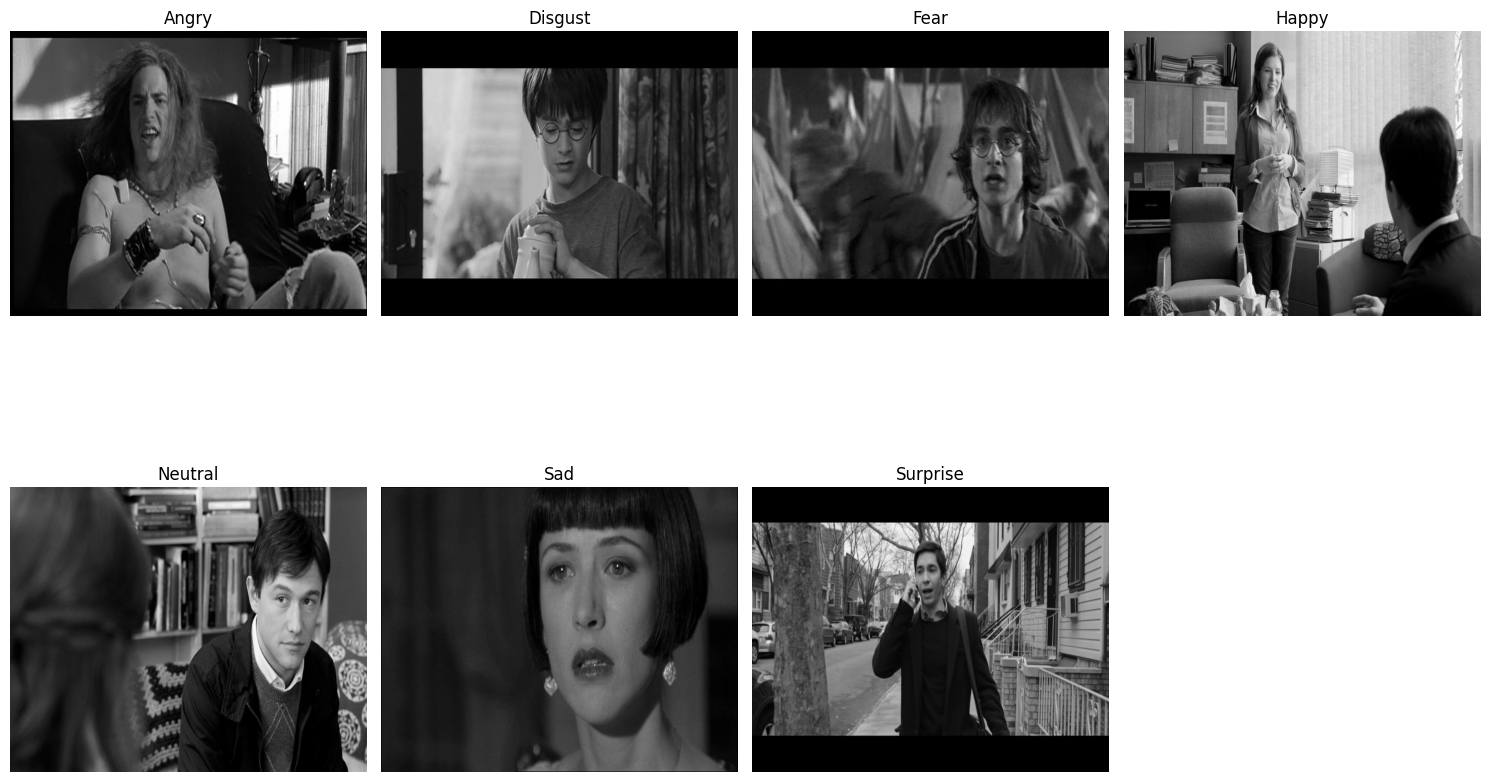

In [6]:
plt.figure(figsize=(15, 10))
for i, category in enumerate(categories):
    if images[category]:
        plt.subplot(2, 4, i+1)
        plt.imshow(images[category][0], cmap='gray')
        plt.title(category)
        plt.axis('off')

plt.tight_layout()
plt.show()

Melihat output image yang udah di konvert ke dalam histogram

In [7]:
images

{'Angry': [array([[1, 1, 1, ..., 0, 1, 1],
         [1, 1, 1, ..., 0, 0, 4],
         [0, 0, 0, ..., 2, 3, 2],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]], dtype=uint8),
  array([[ 0,  1,  1, ...,  3,  2,  0],
         [ 2,  4,  3, ...,  4,  2,  0],
         [ 1,  3,  5, ...,  4,  3,  0],
         ...,
         [ 0, 13, 15, ..., 14, 11,  2],
         [ 0, 15, 18, ..., 17, 16,  2],
         [ 1, 16, 18, ...,  1,  2,  0]], dtype=uint8),
  array([[ 0,  0,  2, ..., 52, 43,  8],
         [ 3,  7, 10, ..., 52, 43,  8],
         [ 2,  5,  9, ..., 52, 42,  7],
         ...,
         [ 3, 12, 21, ..., 51, 31,  2],
         [ 3, 12, 21, ..., 46, 31,  7],
         [ 3, 12, 21, ...,  2,  0,  0]], dtype=uint8),
  array([[  0,   3,   0, ...,  62,  54,  10],
         [  4,  31,  38, ...,  62,  54,  11],
         [  5,  26,  39, ...,  61,  52,  10],
         ...,
         [ 12,  94, 115, ...,  68,  56,   9],
         [ 10,  93, 11

# <p><span style="color: yellow;">Face Detection Using Haar Cascade</span></p>

- Haar-like Feature

    Metode yang sederhana dan keandalannya, Metode ini menggunakan fitur seperti Haar, yang merupakan pola persegi panjang sederhana yang mirip dengan kernel konvolusi dalam pemrosesan gambar.

    $$
    \rho(x, y) = \sum_{x' \leq x, y' \leq y} \psi(x', y')
    $$

    $$
    \sigma(x, y) = \sigma(x, y - 1) + \psi(x, y)
    $$

    $$
    \rho(x, y) = \rho(x - 1, y) + \sigma(x, y)
    $$

     where rho is the integral image and psi(x,y) is the original image. sigma(x,y) is the cumulative row sum.
    The integral image could be obtained in one pass over the original image.

    Example of Features:
<img src="https://docs.opencv.org/3.4/haar_features.jpg" alt="Windowing of Feature"/>
<img src="https://docs.opencv.org/3.4/haar.png" alt="Windowing of Feature in Faces"/>

    Source Learning:
    - https://docs.opencv.org/4.10.0/db/d28/tutorial_cascade_classifier.html
    - https://docs.opencv.org/4.10.0/d2/d99/tutorial_js_face_detection.html#autotoc_md1780
    - https://www.geeksforgeeks.org/face-detection-using-cascade-classifier-using-opencv-python/


- AdaBoost
    Namun di antara semua fitur yang kami hitung, sebagian besar tidak relevan. Misalnya, perhatikan gambar di bawah ini. Baris teratas menunjukkan dua fitur yang bagus. Fitur pertama yang dipilih tampaknya berfokus pada properti bahwa area mata sering kali lebih gelap daripada area hidung dan pipi. Fitur kedua yang dipilih bergantung pada properti bahwa mata lebih gelap daripada pangkal hidung. Namun, jendela yang sama yang diterapkan pada pipi atau tempat lain tidak relevan. Jadi, bagaimana kita memilih fitur terbaik dari 160000+ fitur? Hal ini dicapai oleh Adaboost.
- Cascade Classifiers
    Dalam sebuah gambar, sebagian besar wilayah gambar adalah wilayah non-wajah. Jadi, ada baiknya untuk memiliki metode sederhana untuk memeriksa apakah jendela bukan wilayah wajah. Jika bukan, abaikan dalam satu bidikan. Jangan memprosesnya lagi. Sebaliknya, fokuslah pada wilayah tempat wajah mungkin berada. Dengan cara ini, kita dapat menemukan lebih banyak waktu untuk memeriksa kemungkinan wilayah wajah.

    Untuk ini, mereka memperkenalkan konsep Cascade of Classifiers. Daripada menerapkan semua 6000 fitur pada jendela, kelompokkan fitur-fitur tersebut ke dalam berbagai tahap classifier dan terapkan satu per satu.

In [32]:
# # Reading the image 
# img = cv.imread('images/train/Angry/AlexEmma_000958320_00000022.png') 

# # Converting image to grayscale 
# gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 

# # Loading the required haar-cascade xml classifier file 
# haar_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml') 

# Applying the face detection method on the grayscale image 
# faces_rect = haar_cascade.detectMultiScale(gray_img, scaleFactor = 1.1, minNeighbors = 3, minSize=(40, 40))

# Iterating through rectangles of detected faces 
# for (x, y, w, h) in faces_rect: 
# 	cv.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2) 

# cv.imshow('Detected faces', img) 

# cv.waitKey(0) 


-1

## <p><span style="color: orange;">Pembuatan Fungsi Haarcascade</span></p>


- Pertama fungsi "detect_faces" untuk mendeteki wajah yang diimport melalui library open cv, jadi di dalam satu file "haarcascade_frontalface_default.xml" sudah tersedia haar, adaboost, cascade.
- Kedua fungsi "draw_faces" untuk menggambar bounding box dalam gambar
- Ketiga fungsi "create_folder_structure" untuk membuat folder menyimpan hasil crop faces

In [47]:
# Fungsi untuk mendeteksi wajah menggunakan Haar Cascade
def detect_faces(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces_rect = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3, minSize=(40, 40))
    return faces_rect

# Fungsi untuk menggambar kotak di sekitar wajah yang terdeteksi
def draw_faces(image, faces):
    for (x, y, w, h) in faces:
        cv.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
    return image

# Membuat folder untuk menyimpan hasil crop
def create_folder_structure(base_path, labels):
    for label in labels:
        folder_path = os.path.join(base_path, label)
        if os.path.exists(folder_path):
            # Jika folder ada, hapus folder tersebut
            shutil.rmtree(folder_path)
            print(f"Sudah ada folder, folder {label} lama dihapus dan diperbarui (DONE)")
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

## Proses deteksi dan simpan wajah

In [57]:
# Asumsikan 'image_paths' sudah didefinisikan
base_output_path = "images/cropped"  # Path dasar untuk menyimpan hasil crop
labels = list(image_paths.keys())  # Ambil semua label dari image_paths
create_folder_structure(base_output_path, labels)

noFaces = {}
noFacesPath = {}

# Proses deteksi dan penyimpanan wajah
for emotion, paths in tqdm(image_paths.items(), desc="Memproses label", unit=" label"):
    print(f"Memproses label: {emotion}")
    for image_path in paths:
        image = cv.imread(image_path)
        if image is not None:
            faces = detect_faces(image)  # Deteksi wajah pada gambar

            if len(faces) > 0:  # Pastikan ada wajah yang terdeteksi

                # Gambar kotak di sekitar wajah yang terdeteksi
                # image_with_faces = draw_faces(image, faces)

                # Tampilkan gambar dengan deteksi wajah menggunakan cv2_imshow
                # cv2_imshow(image_with_faces)

                for i, (x, y, w, h) in enumerate(faces):
                    face = image[y:y+h, x:x+w]  # Crop wajah dari gambar asli
                    face_output_path = os.path.join(base_output_path, emotion, f"{os.path.basename(image_path).split('.')[0]}_face_{i+1}.jpg")
                    cv.imwrite(face_output_path, face)  # Simpan gambar crop wajah


            else:
                if emotion not in noFaces:
                    noFaces[emotion] = 0  # Inisialisasi dengan 0 jika key belum ada
                    noFacesPath[emotion] = []  # Inisialisasi dengan 0 jika key belum ada
                else:
                    noFaces[emotion] += 1 #Tidak ada wajah yang terdeteksi di gambar.
                    noFacesPath[emotion].append(image_path)
        else:
            print(f"Gambar tidak dapat dimuat: {image_path}")

print("Pemrosesan selesai.")

Sudah ada folder, folder Angry lama dihapus dan diperbarui (DONE)
Sudah ada folder, folder Disgust lama dihapus dan diperbarui (DONE)
Sudah ada folder, folder Fear lama dihapus dan diperbarui (DONE)
Sudah ada folder, folder Happy lama dihapus dan diperbarui (DONE)
Sudah ada folder, folder Neutral lama dihapus dan diperbarui (DONE)
Sudah ada folder, folder Sad lama dihapus dan diperbarui (DONE)
Sudah ada folder, folder Surprise lama dihapus dan diperbarui (DONE)


Memproses label:   0%|          | 0/7 [00:00<?, ? label/s]

Memproses label: Angry


Memproses label:  14%|█▍        | 1/7 [00:13<01:22, 13.77s/ label]

Memproses label: Disgust


Memproses label:  29%|██▊       | 2/7 [00:18<00:41,  8.36s/ label]

Memproses label: Fear


Memproses label:  43%|████▎     | 3/7 [00:24<00:29,  7.46s/ label]

Memproses label: Happy


Memproses label:  57%|█████▋    | 4/7 [00:39<00:30, 10.24s/ label]

Memproses label: Neutral


Memproses label:  71%|███████▏  | 5/7 [00:49<00:20, 10.27s/ label]

Memproses label: Sad


Memproses label:  86%|████████▌ | 6/7 [01:02<00:11, 11.20s/ label]

Memproses label: Surprise


Memproses label: 100%|██████████| 7/7 [01:09<00:00,  9.91s/ label]

Pemrosesan selesai.


In [55]:
print(f"Yang tidak terdeteksi wajah pada image: {noFaces}")

Yang tidak terdeteksi wajah pada image: {'Angry': 38, 'Disgust': 11, 'Fear': 21, 'Happy': 27, 'Neutral': 23, 'Sad': 38, 'Surprise': 14}


In [56]:
print(f"Yang tidak terdeteksi wajah pada image: {noFacesPath}")

Yang tidak terdeteksi wajah pada image: {'Angry': ['images/train\\Angry\\AndSoonCameDarkness_005445120_00000053.png', 'images/train\\Angry\\Contraband_011817120_00000011.png', 'images/train\\Angry\\CryingGame_013249040_00000040.png', 'images/train\\Angry\\DeepBlueSea_012801400_00000011.png', 'images/train\\Angry\\DeepBlueSea_012801400_00000048.png', 'images/train\\Angry\\Descendants_003858520_00000022.png', 'images/train\\Angry\\GhostShip_011515080_00000073.png', 'images/train\\Angry\\GirlWithAPearlEarring_012432920_00000021.png', 'images/train\\Angry\\GirlWithAPearlEarring_012432920_00000031.png', 'images/train\\Angry\\HarryPotter_Deathly_Hallows_1_003307280_00000001.png', 'images/train\\Angry\\LittleManhattan_010116283_00000027.png', 'images/train\\Angry\\MissMarch_004423640_00000028.png', 'images/train\\Angry\\OceansEleven_001416400_00000048.png', 'images/train\\Angry\\OceansEleven_001637640_00000014.png', 'images/train\\Angry\\OceansEleven_005846280_00000037.png', 'images/train\\An

# Sesi nyoba2

In [57]:
# Misalkan kita punya gambar dengan wajah
image = cv.imread('images/train/Angry/Airheads_000519240_00000005.png')

# Koordinat dan ukuran bounding box dari hasil deteksi wajah
x, y, w, h = 1, 100, 200, 200

# Gambar kotak pembatas pada gambar
cv.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Warna biru dengan ketebalan garis 2

# Tampilkan gambar
cv.imshow('Output', image)
cv.waitKey(0)
cv.destroyAllWindows()


In [36]:
# Set opsi tampilan NumPy untuk menampilkan semua elemen array
np.set_printoptions(threshold=np.inf)

# Membaca gambar dari file
image_path = 'images/train/Angry/Airheads_000519240_00000005.png'  # Ganti dengan path gambar Anda
image = cv.imread(image_path)

# Periksa apakah gambar berhasil dimuat
if image is not None:
    # Mengubah gambar menjadi array NumPy
    image_array = np.array(image)

    # Menampilkan array NumPy dari gambar
    print("Array NumPy dari gambar:")
    # print(image_array)

    import json

    # Mengubah array NumPy menjadi list of lists
    image_array_list = image_array.tolist()

    # Menyimpan ke file JSON
    with open('image_array.json', 'w') as f:
        json.dump(image_array_list, f)

else:
    print("Gambar tidak dapat dimuat. Periksa kembali path gambar Anda.")


Array NumPy dari gambar:


# <p><span style="color: yellow;">NDF (Neighborhood Difference Features)</span></p>

## <p><span style="color: orange;">FORMULA</span></p>

- NDF Formula
   > Our NDF formulated different patterns based on the relationships between neighboring regions. For appearance information, we explored the neighborhood in numerous directions and scaled to compute regional patterns.

   $$
   (PN)_{M,N} = \sum_{n=0}^{M-1} 2^n x_n \tau_1(S_n - S_c)
   $$

   $$
   \tau_1 = \begin{cases} 
   1 & \text{if } (S_n - S_c) > 0 \\
   0 & \text{otherwise} 
   \end{cases}
   $$

   > where M and N are the radii of neighbors and the number of neighbors for the pattern number.


- Histogram Formula
   > After calculating the PN of a face, a histogram is computed as,

   $$
   \pi_1(l) = \sum_{x=1}^{M} \sum_{y=1}^{N} \tau_2(PN_{x,y}, l) : l \in [0, 2^M - 1]
   $$

   $$
   \tau_2(a, b) = \begin{cases} 
   1 & \text{if } a = b \\
   0 & \text{otherwise} 
   \end{cases}
   $$

   > The relationship between regions in terms of these pixels was exploited, and a pattern number was assigned. We constructed a histogram to represent the face in the form of NDF

- Neighboring Formula
   > For neighboring pixels Sn and a center pixel Sc, NDF could be formulated as

   1. Untuk n = 1:
      $G_1^n = S_8 - S_n, G_2^n = S_{n+1} - S_n$

   2. Untuk n = 2, ..., 7:
      $G_1^n = S_{n-1} - S_n, G_2^n = S_{n+1} - S_n$

   3. Untuk n = 8:
      $G_1^n = S_{n-1} - S_n, G_2^n = S_1 - S_n$

    > We found the difference of each neighbor with two other neighbors in $G_1^n$ and $G_2^n$. Considering these two difference, we assigned a pattern number to each neighbor,

   $$\tau_3(G_1^n - G_2^n) = \begin{cases} 
   1, & \text{jika } G_1^n \geq 0 \text{ dan } G_2^n \geq 0 \\
   1, & \text{jika } G_1^n < 0 \text{ dan } G_2^n < 0 \\
   0, & \text{jika } G_1^n \geq 0 \text{ dan } G_2^n < 0 \\
   0, & \text{jika } G_1^n < 0 \text{ dan } G_2^n \geq 0
   \end{cases}$$


- NDF Formula for Central Pixel
   > For the central pixel Sc, NDF could be found using the above numbers, and the histogram for NDF map could be calculated in the equations,

   $$NDF(S_c) = \sum_{n=1}^8 2^{n-1} \sqrt{S_c}(G_1^n - G_2^n)$$

   $$\pi_2(NDF) = \sum_{x=1}^M \sum_{y=1}^N \tau_2(NDF_{x,y,l}) : l \in [0, 2^8 - 1]$$

   > Di mana:
   > - $M$ dan $N$ adalah batas sumasi
   > - $\tau_2$ adalah fungsi yang perlu didefinisikan
   > - $NDF_{x,y,l}$ adalah elemen dari array NDF
   > - $l$ berada dalam rentang $[0, 255]$

> NDF merepresentasikan fitur-fitur baru yang diperoleh dengan mengekstraksi hubungan antara daerah-daerah tetangga dengan mempertimbangkannya secara timbal balik. NDF menghitung hubungan daerah-daerah tetangga dengan daerah pusat. Dalam kerangka kerja yang diusulkan, deteksi wajah dan NDF bekerja secara berurutan karena keduanya saling bersaing berdasarkan karakteristik yang direpresentasikan secara individual.

|1|2|3|
|-|-|-|
|4|C|5|
|6|7|8|

## <p><span style="color: orange;">Pembuatan Fungsi NDF</span></p>

 NDF Formula for Central Pixel
   > For the central pixel Sc, NDF could be found using the above numbers, and the histogram for NDF map could be calculated in the equations,

   $$NDF(S_c) = \sum_{n=1}^8 2^{n-1} \sqrt{S_c}(G_1^n - G_2^n)$$

   $$\pi_2(NDF) = \sum_{x=1}^M \sum_{y=1}^N \tau_2(NDF_{x,y,l}) : l \in [0, 2^8 - 1]$$

   > Di mana:
   > - $M$ dan $N$ adalah batas sumasi
   > - $\tau_2$ adalah fungsi yang perlu didefinisikan
   > - $NDF_{x,y,l}$ adalah elemen dari array NDF
   > - $l$ berada dalam rentang $[0, 255]$

> NDF merepresentasikan fitur-fitur baru yang diperoleh dengan mengekstraksi hubungan antara daerah-daerah tetangga dengan mempertimbangkannya secara timbal balik. NDF menghitung hubungan daerah-daerah tetangga dengan daerah pusat. Dalam kerangka kerja yang diusulkan, deteksi wajah dan NDF bekerja secara berurutan karena keduanya saling bersaing berdasarkan karakteristik yang direpresentasikan secara individual.

In [1]:
def calculate_gn_differences(image):
    padded_image = np.pad(image.astype(np.int16), pad_width=1, mode='constant', constant_values=0)
    height, width = image.shape
    gn_map = np.zeros((height, width, 8, 2), dtype=int)

    for i in range(1, height + 1):
        for j in range(1, width + 1):
            neighbors = [
                padded_image[i-1, j-1],  # S1
                padded_image[i-1, j],    # S2
                padded_image[i-1, j+1],  # S3
                padded_image[i, j+1],    # S4
                padded_image[i+1, j+1],  # S5
                padded_image[i+1, j],    # S6
                padded_image[i+1, j-1],  # S7
                padded_image[i, j-1],    # S8
            ]

            gn1_diffs = [neighbors[7] - neighbors[k] for k in range(8)]
            gn2_diffs = [neighbors[(k+1) % 8] - neighbors[k] for k in range(8)]

            gn_map[i-1, j-1, :, 0] = gn1_diffs
            gn_map[i-1, j-1, :, 1] = gn2_diffs

    return gn_map

def tau3(gn_diffs):
    gn1, gn2 = gn_diffs[:, 0], gn_diffs[:, 1]
    pattern_number = np.zeros(8, dtype=int)

    for k in range(8):
        if gn1[k] >= 0 and gn2[k] >= 0:
            pattern_number[k] = 1
        elif gn1[k] < 0 and gn2[k] < 0:
            pattern_number[k] = 1
        else:
            pattern_number[k] = 0

    return pattern_number

def calculate_ndf_image(image):
    gn_map = calculate_gn_differences(image)
    height, width = image.shape
    ndf_image = np.zeros((height, width), dtype=int)

    for i in range(height):
        for j in range(width):
            pattern_number = tau3(gn_map[i, j])
            ndf_value = int("".join(map(str, pattern_number)), 2)
            ndf_image[i, j] = ndf_value

    return ndf_image

def extract_ndf_features(image_folder, label, img_size=(64, 64)):
    features = []
    labels = []

    # Iterate over images without using tqdm here
    for image_name in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_name)
        image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

        # Resize image to a fixed size
        image = cv.resize(image, img_size)

        ndf_image = calculate_ndf_image(image)

        # Flatten the NDF image to use as feature vector
        feature_vector = ndf_image.flatten()
        features.append(feature_vector)
        labels.append(label)

    return np.array(features), np.array(labels)

def visualize_ndf(ndf_image):
    # Normalize NDF image for better visualization
    normalized_ndf = cv.normalize(ndf_image, None, 0, 255, cv.NORM_MINMAX)

    # Convert to uint8 (grayscale) format
    normalized_ndf = normalized_ndf.astype(np.uint8)

    # Display the NDF image
    plt.figure(figsize=(6, 6))
    plt.imshow(normalized_ndf, cmap='gray')
    plt.title("NDF Visualization")
    plt.axis('off')
    plt.show()

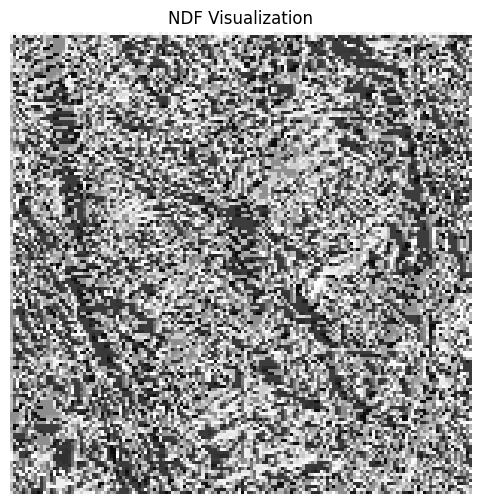

In [60]:
# Example usage
image = cv.imread('images/cropped/Fear/TheShining_004603760_00000043_face_2.jpg', cv.IMREAD_GRAYSCALE)  # Load image in grayscale
ndf_image = calculate_ndf_image(image)
visualize_ndf(ndf_image)


In [ ]:
# Assuming you have a dataset of images categorized by emotions
dataset_folder = '/content/drive/MyDrive/SCRIPTC/cropped_faces'

all_features = []
all_labels = []

# Outer loop over classes with tqdm
for emotion in tqdm(categories, desc="Processing categories"):
    folder_path = os.path.join(dataset_folder, emotion)

    # You can still use tqdm inside extract_ndf_features if you want, but not necessary
    features, labels = extract_ndf_features(folder_path, emotion, img_size=(64, 64))
    all_features.append(features)
    all_labels.append(labels)

all_features = np.vstack(all_features)
all_labels = np.hstack(all_labels)

In [ ]:
# Proceed with training and evaluation
X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.3, random_state=42)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))